In [1]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
DATA_PATH = "../data/raw"
PROJECT_BASEPATH = os.path.dirname(os.getcwd()) 
sys.path.append(PROJECT_BASEPATH)

# Custom data transformers from local module
from data_preparation.custom_transformers import DurationTransformer, DurationOutlierRemover, IdImputer, OneHotEncoder

print("files", os.listdir(DATA_PATH))
train_data = pd.read_parquet(os.path.join(DATA_PATH, "fhv_tripdata_2021-01.parquet"))
val_data = pd.read_parquet(os.path.join(DATA_PATH, "fhv_tripdata_2021-02.parquet"))

files ['fhv_tripdata_2021-01.parquet', 'fhv_tripdata_2021-02.parquet']


# Q1. Downloading the data

In [3]:
Q1 = train_data.shape[0]
print(Q1)

1154112


# Q2. Computing duration

19.167224093791006
Removed 44286 rows


<AxesSubplot:>

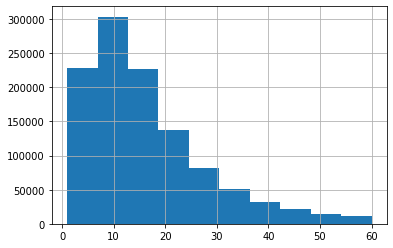

In [4]:

duration_transformer = DurationTransformer().fit()
outlier_transformer = DurationOutlierRemover(verbose=True, min_value=1, max_value=60)
train_data_cleaned = duration_transformer.transform(train_data)
Q2 = train_data_cleaned['duration'].mean()
print(Q2)
train_data_cleaned, Y = outlier_transformer.transform(train_data_cleaned)
train_data_cleaned['duration'].hist()

# Q3. Missing values

In [5]:
impute_transformer = IdImputer(["PUlocationID", "DOlocationID"], -1)
train_data_cleaned = impute_transformer.transform(train_data_cleaned)
missing_count = train_data_cleaned.loc[train_data_cleaned['PUlocationID'] == -1.0].shape[0]
Q3 = missing_count / train_data_cleaned.shape[0]
print(Q3)

0.8352732770722617


# Q4. One-hot encoding

In [6]:
one_hot_transformer = OneHotEncoder(["PUlocationID", "DOlocationID"])
one_hot_transformer.fit(train_data_cleaned)
train_array = one_hot_transformer.transform(train_data_cleaned)
Q4 = train_array.shape[1]
print(Q4)

525


# Q5. Training a model

In [7]:
target_pipeline = Pipeline([ 
    ("duration", DurationTransformer()),
    ("outlier", DurationOutlierRemover(verbose=False, min_value=1, max_value=60)),
])

train_pipeline = Pipeline([ 
    ("imputer", IdImputer(["PUlocationID", "DOlocationID"], -1)),
    ("encoder", OneHotEncoder(["PUlocationID", "DOlocationID"])),
    ("regression", LinearRegression()),
])

In [8]:
X, Y = target_pipeline.fit_transform(train_data, None)
train_pipeline.fit(X, Y)
Y_hat = train_pipeline.predict(X).clip(1, 60)
Q5 = mean_squared_error(Y, Y_hat, squared=False)
print(Q5)

10.528533522654985


# Q6. Evaluating the model

In [9]:
X_val, Y_val = target_pipeline.transform(val_data)
Y_val_hat = train_pipeline.predict(X_val).clip(1, 60)
Q6 = mean_squared_error(Y_val, Y_val_hat, squared=False)
print(Q6)

11.014272665082515


In [10]:
print("Q1", Q1)
print("Q2", Q2)
print("Q3", Q3)
print("Q4", Q4)
print("Q5", Q5)
print("Q6", Q6)

Q1 1154112
Q2 19.167224093791006
Q3 0.8352732770722617
Q4 525
Q5 10.528533522654985
Q6 11.014272665082515
